## TsetlinMachine Model Pipline

### Install Required Py packages

In [ ]:
!pip install pyTsetlinMachine
!pip install split-folders

  Preparing metadata (setup.py) ... done
  Created wheel for pyTsetlinMachine: filename=pyTsetlinMachine-0.6.6-cp310-cp310-linux_x86_64.whl size=59499 sha256=53a46e89f130f102ab1f2730f4169e2b534e9f5b960367bbdeb7b405b53543b1
  Stored in directory: /root/.cache/pip/wheels/b0/b0/c5/07c4cb8bb93c5325bdc2c2a070b565f54df717d5d11f0c6802
Successfully built pyTsetlinMachine


### Step 1: Import Required Libraries

In [ ]:
import os
import numpy as np
import cv2
from pyTsetlinMachine.tm import MultiClassConvolutionalTsetlinMachine2D
from time import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import splitfolders
from torchvision import datasets, transforms
from time import time

### Step 2: Mount Google Drive and Load Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
data_dir = '/content/drive/My Drive/data'
output_dir = '/content/dataset'

Mounted at /content/drive


### Step 3: Split the Dataset into train ,test and validation sets

In [ ]:
# Split the dataset into train ,test and validation sets
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, .1, .1))

Copying files: 752 files [00:18, 40.14 files/s] 


In [ ]:
# Function to preprocess and convert images to binary
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))
    _, img_bin = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)
    return img_bin

def load_data_as_binary(data_dir):
    X = []
    y = []
    class_names = []
    for class_idx, class_dir in enumerate(sorted(os.listdir(data_dir))):
        class_path = os.path.join(data_dir, class_dir)
        class_names.append(class_dir)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img_bin = preprocess_image(img_path)
                X.append(img_bin)
                y.append(class_idx)
    return np.array(X), np.array(y), class_names

# Convert images to binary format
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

X_train_bin, y_train_bin, class_names = load_data_as_binary(train_dir)
X_val_bin, y_val_bin, _ = load_data_as_binary(val_dir)
X_test_bin, y_test_bin, _ = load_data_as_binary(test_dir)

# Reshape data to add the channel dimension
X_train_bin = X_train_bin.reshape((X_train_bin.shape[0], 28, 28, 1))
X_val_bin = X_val_bin.reshape((X_val_bin.shape[0], 28, 28, 1))
X_test_bin = X_test_bin.reshape((X_test_bin.shape[0], 28, 28, 1))

### Step 4: Exloratory Data Analysis

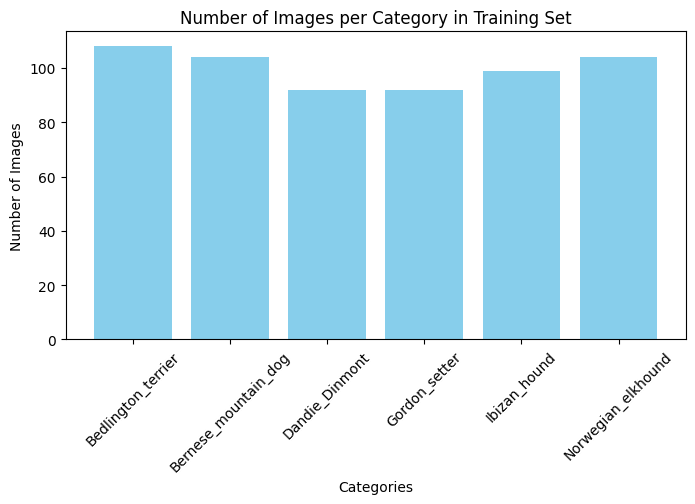

In [ ]:
# Get the class names and number of images in each class
class_counts = [0] * len(class_names)
for label in y_train_bin:
    class_counts[label] += 1

# Plot the bar chart
plt.figure(figsize=(8, 4))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category in Training Set')
plt.xticks(rotation=45)
plt.show()

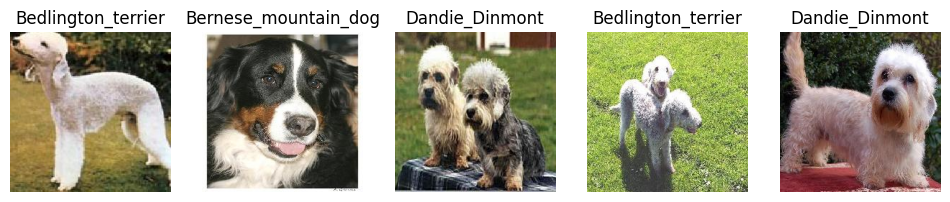

In [ ]:
# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the training data
train_data = datasets.ImageFolder('/content/drive/My Drive/data', transform=transform)

# Get the class names
class_names = train_data.classes

# Function to display random images from the dataset
def show_random_images(dataset, num_images=5):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(class_names[label])
        plt.axis('off')
    plt.show()

# Display random images from the training dataset
show_random_images(train_data)

### Step 5:TMs Model Hyperparameters Tuning

In [ ]:
# Hyperparameters to experiment with
num_clauses_list = [2000, 3000, 4000]
threshold_list = [40*100, 50*100, 60*100]
specificity_list = [2.0, 5.0, 10.0]
patch_size_list = [(5, 5), (10, 10), (15, 15)]

#
for num_clauses in num_clauses_list:
    for threshold in threshold_list:
        for specificity in specificity_list:
            for patch_size in patch_size_list:
                print(f"Training with num_clauses={num_clauses}, threshold={threshold}, specificity={specificity}, patch_size={patch_size}")

                tm = MultiClassConvolutionalTsetlinMachine2D(
                    num_clauses, threshold, specificity, patch_size, weighted_clauses=True
                )

                print("\nAccuracy over 30 epochs:\n")
                for i in range(30):
                    start = time()
                    tm.fit(X_train_bin, y_train_bin, epochs=1, incremental=True)
                    stop = time()

                    accuracy = 100 * (tm.predict(X_val_bin) == y_val_bin).mean()
                    print(f"Epoch #{i+1} Accuracy: {accuracy:.2f}% (Time: {stop-start:.2f}s)")

                # Evaluate on the test set (optional)
                y_pred_bin = tm.predict(X_val_bin)
                print("Evaluation of Tsetlin Machine Model")
                print(classification_report(y_val_bin, y_pred_bin, target_names=class_names))
                cm_bin = confusion_matrix(y_val_bin, y_pred_bin)
                print("Confusion Matrix:")
                print(cm_bin)


Training with num_clauses=2000, threshold=4000, specificity=2.0, patch_size=(5, 5)

Accuracy over 30 epochs:

Epoch #1 Accuracy: 26.03% (Time: 10.65s)
Epoch #2 Accuracy: 31.51% (Time: 9.31s)
Epoch #3 Accuracy: 28.77% (Time: 9.07s)
Epoch #4 Accuracy: 41.10% (Time: 7.54s)
Epoch #5 Accuracy: 42.47% (Time: 7.11s)
Epoch #6 Accuracy: 42.47% (Time: 8.91s)
Epoch #7 Accuracy: 38.36% (Time: 8.86s)
Epoch #8 Accuracy: 38.36% (Time: 6.97s)
Epoch #9 Accuracy: 35.62% (Time: 7.45s)
Epoch #10 Accuracy: 41.10% (Time: 8.81s)
Epoch #11 Accuracy: 39.73% (Time: 8.03s)
Epoch #12 Accuracy: 38.36% (Time: 6.88s)
Epoch #13 Accuracy: 38.36% (Time: 8.52s)
Epoch #14 Accuracy: 41.10% (Time: 8.70s)
Epoch #15 Accuracy: 41.10% (Time: 6.80s)
Epoch #16 Accuracy: 41.10% (Time: 7.06s)
Epoch #17 Accuracy: 39.73% (Time: 8.63s)
Epoch #18 Accuracy: 41.10% (Time: 8.00s)
Epoch #19 Accuracy: 42.47% (Time: 6.78s)
Epoch #20 Accuracy: 39.73% (Time: 8.30s)
Epoch #21 Accuracy: 41.10% (Time: 8.59s)
Epoch #22 Accuracy: 34.25% (Time: 6.7

### Step 6: Model Definition

In [ ]:
# Initialize the MultiClassConvolutionalTsetlinMachine2D model
tm = MultiClassConvolutionalTsetlinMachine2D(4000, 40*100, 2.0, (5, 5), weighted_clauses=True)


print("\nAccuracy over 30 epochs:\n")
for i in range(30):
    start = time()
    tm.fit(X_train_bin, y_train_bin, epochs=1, incremental=True)
    stop = time()

    accuracy = 100*(tm.predict(X_val_bin) == y_val_bin).mean()

    print("#%d Accuracy: %.2f%% (%.2fs)" % (i+1, accuracy, stop-start))


Accuracy over 30 epochs:

#1 Accuracy: 35.62% (17.06s)
#2 Accuracy: 31.51% (16.19s)
#3 Accuracy: 35.62% (16.52s)
#4 Accuracy: 41.10% (15.86s)
#5 Accuracy: 41.10% (15.89s)
#6 Accuracy: 42.47% (15.51s)
#7 Accuracy: 42.47% (15.47s)
#8 Accuracy: 46.58% (15.33s)
#9 Accuracy: 41.10% (15.27s)
#10 Accuracy: 43.84% (15.27s)
#11 Accuracy: 39.73% (15.17s)
#12 Accuracy: 42.47% (15.65s)
#13 Accuracy: 39.73% (15.17s)
#14 Accuracy: 38.36% (15.04s)
#15 Accuracy: 36.99% (15.01s)
#16 Accuracy: 39.73% (14.92s)
#17 Accuracy: 39.73% (15.26s)
#18 Accuracy: 42.47% (14.86s)
#19 Accuracy: 45.21% (14.87s)
#20 Accuracy: 38.36% (14.83s)
#21 Accuracy: 38.36% (14.78s)
#22 Accuracy: 42.47% (15.04s)
#23 Accuracy: 43.84% (14.69s)
#24 Accuracy: 42.47% (14.72s)
#25 Accuracy: 42.47% (14.71s)
#26 Accuracy: 45.21% (14.70s)
#27 Accuracy: 43.84% (14.84s)
#28 Accuracy: 45.21% (14.67s)
#29 Accuracy: 43.84% (14.66s)
#30 Accuracy: 42.47% (14.67s)


### Step 7: Model Evaluation

Evaluation of Tsetlin Machine Model
                      precision    recall  f1-score   support

  Bedlington_terrier       0.56      0.33      0.42        15
Bernese_mountain_dog       0.43      0.43      0.43        14
      Dandie_Dinmont       0.53      0.75      0.62        12
       Gordon_setter       0.69      0.69      0.69        13
        Ibizan_hound       0.31      0.38      0.34        13
  Norwegian_elkhound       0.55      0.46      0.50        13

            accuracy                           0.50        80
           macro avg       0.51      0.51      0.50        80
        weighted avg       0.51      0.50      0.50        80



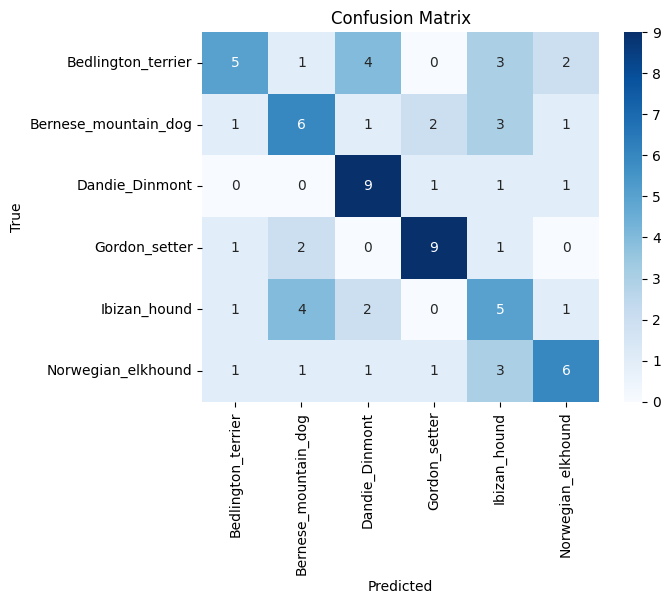

In [ ]:
# Predict on the test set
y_pred_bin = tm.predict(X_test_bin)

# Print evaluation report
print("Evaluation of Tsetlin Machine Model")
print(classification_report(y_test_bin, y_pred_bin, target_names=class_names))

# Print and plot confusion matrix
cm_bin = confusion_matrix(y_test_bin, y_pred_bin)
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()